In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage import util
from scipy import ndimage
from skimage.exposure import match_histograms

#Downloading the Images:




---


![](https://drive.google.com/uc?export=view&id=1vtvIhQdv6pmCoxJs2hqGrb_REr7a6IM2)
![](https://drive.google.com/uc?export=view&id=1wiKlGqtivCyIOGUx9qlZ86K-man6SUIm)
![](https://drive.google.com/uc?export=view&id=1ysC3pTsBFjLLnetmmcCxR50BrVbN4DAQ)
![](https://drive.google.com/uc?export=view&id=1FL58ExbcIhciZe3TBFdn9M4U84w0Jgum)
![](https://drive.google.com/uc?export=view&id=1GwZRf1ZwwegM8ch-vBAIsSTOmZQCfVFF)

In [ ]:
!gdown --id 1GwZRf1ZwwegM8ch-vBAIsSTOmZQCfVFF
!gdown --id 1FL58ExbcIhciZe3TBFdn9M4U84w0Jgum
!gdown --id 1vtvIhQdv6pmCoxJs2hqGrb_REr7a6IM2
!gdown --id 1wiKlGqtivCyIOGUx9qlZ86K-man6SUIm
!gdown --id 1ysC3pTsBFjLLnetmmcCxR50BrVbN4DAQ

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GwZRf1ZwwegM8ch-vBAIsSTOmZQCfVFF
To: /content/Echinocytes.jpeg
100% 12.4k/12.4k [00:00<00:00, 28.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1FL58ExbcIhciZe3TBFdn9M4U84w0Jgum
To: /content/Acanthocytes.jpeg
100% 10.3k/10.3k [00:00<00:00, 18.2MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: h

# SECTION 1 - Textures

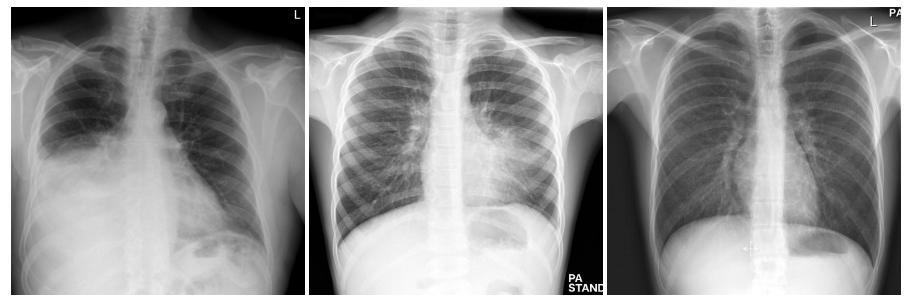

### 1A:  Using a set of minimum 5 textural descriptors of your choice (e.g. GLCM-entropy counts as one, GLCM-IDM is another one, GLRLM-SRE is another one, etc), design a score able to objectively distinguish the cases. You can choose for example to average all five textures, or apply weights to them. Be creative

Ref: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html

In [ ]:
image_effusion = cv2.imread("effusion.jpg", cv2.IMREAD_GRAYSCALE)
image_inflitration = cv2.imread("inflitration.jpg", cv2.IMREAD_GRAYSCALE)
image_pneumonia = cv2.imread("pneumonia.jpg", cv2.IMREAD_GRAYSCALE)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage import data

PATCH_SIZE = 21
def compute_features(patch):
    glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]

    # Compute GLRLM Short Run Emphasis (SRE)
    sre = np.sum(glcm[:, :, 0, 0] ** 2) / np.sum(glcm[:, :, 0, 0])

    return dissimilarity, correlation, homogeneity, energy, sre

def compute_score(features, weights):
    score = sum([features[i] * weights[key] for i, key in enumerate(weights.keys())])
    return score

def analyze_texture_features(weights, image_effusion , muscle_locations , healthy_locations, pleural_locations, name):
    # select some patches from muscle areas
    # muscle_locations = [(350, 950), (500, 1050), (700, 1015)]
    muscle_patches = [image_effusion[loc[0]: loc[0] + PATCH_SIZE, loc[1]: loc[1] + PATCH_SIZE] for loc in muscle_locations]

    # select some patches from healthy areas
    # healthy_locations = [(300, 680), (400, 750), (500, 750)]
    healthy_patches = [image_effusion[loc[0]: loc[0] + PATCH_SIZE, loc[1]: loc[1] + PATCH_SIZE] for loc in healthy_locations]

    # select some patches from fluid-filled areas
    # pleural_locations = [(850, 300), (900, 380), (1050, 300)]
    pleural_patches = [image_effusion[loc[0]: loc[0] + PATCH_SIZE, loc[1]: loc[1] + PATCH_SIZE] for loc in pleural_locations]

    # compute GLCM properties for each patch and calculate score
    muscle_scores, healthy_scores, pleural_scores = [], [], []


    for patch in muscle_patches:
        features = compute_features(patch)
        score = compute_score(features, weights)
        muscle_scores.append(score)

    for patch in healthy_patches:
        features = compute_features(patch)
        score = compute_score(features, weights)
        healthy_scores.append(score)

    for patch in pleural_patches:
        features = compute_features(patch)
        score = compute_score(features, weights)
        pleural_scores.append(score)


    fig = plt.figure(figsize=(12, 18))

    ax = fig.add_subplot(4, 3, 1)
    ax.imshow(image_effusion, cmap=plt.cm.gray, vmin=0, vmax=255)
    for y, x in muscle_locations:
        ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'ys')
    for y, x in healthy_locations:
        ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
    for y, x in pleural_locations:
        ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'rs')
    ax.set_title('Original Image')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('image')


    ax = fig.add_subplot(4, 3, 2)
    ax.plot(muscle_scores, 'yo-', label='Muscle')
    ax.plot(healthy_scores, 'bo-', label='Healthy')
    ax.plot(pleural_scores, 'ro-', label=name)
    ax.set_xlabel('Patch Index')
    ax.set_ylabel('Texture Score')
    ax.legend()
    ax.set_title('Texture Scores')

    num_patches = max(len(muscle_patches), len(healthy_patches), len(pleural_patches))


    for i, patch in enumerate(muscle_patches):
        ax = fig.add_subplot(4, num_patches, num_patches * 1 + i + 1)
        ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
        ax.set_title(f"Muscle {i + 1}")
        ax.axis('off')


    for i, patch in enumerate(healthy_patches):
        ax = fig.add_subplot(4, num_patches, num_patches * 2 + i + 1)
        ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
        ax.set_title(f"Healthy {i + 1}")
        ax.axis('off')

    for i, patch in enumerate(pleural_patches):
        ax = fig.add_subplot(4, num_patches, num_patches * 3 + i + 1)
        ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
        ax.set_title(f"{name} {i + 1}")
        ax.axis('off')

    fig.suptitle('Grey Level Co-occurrence Matrix Features', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


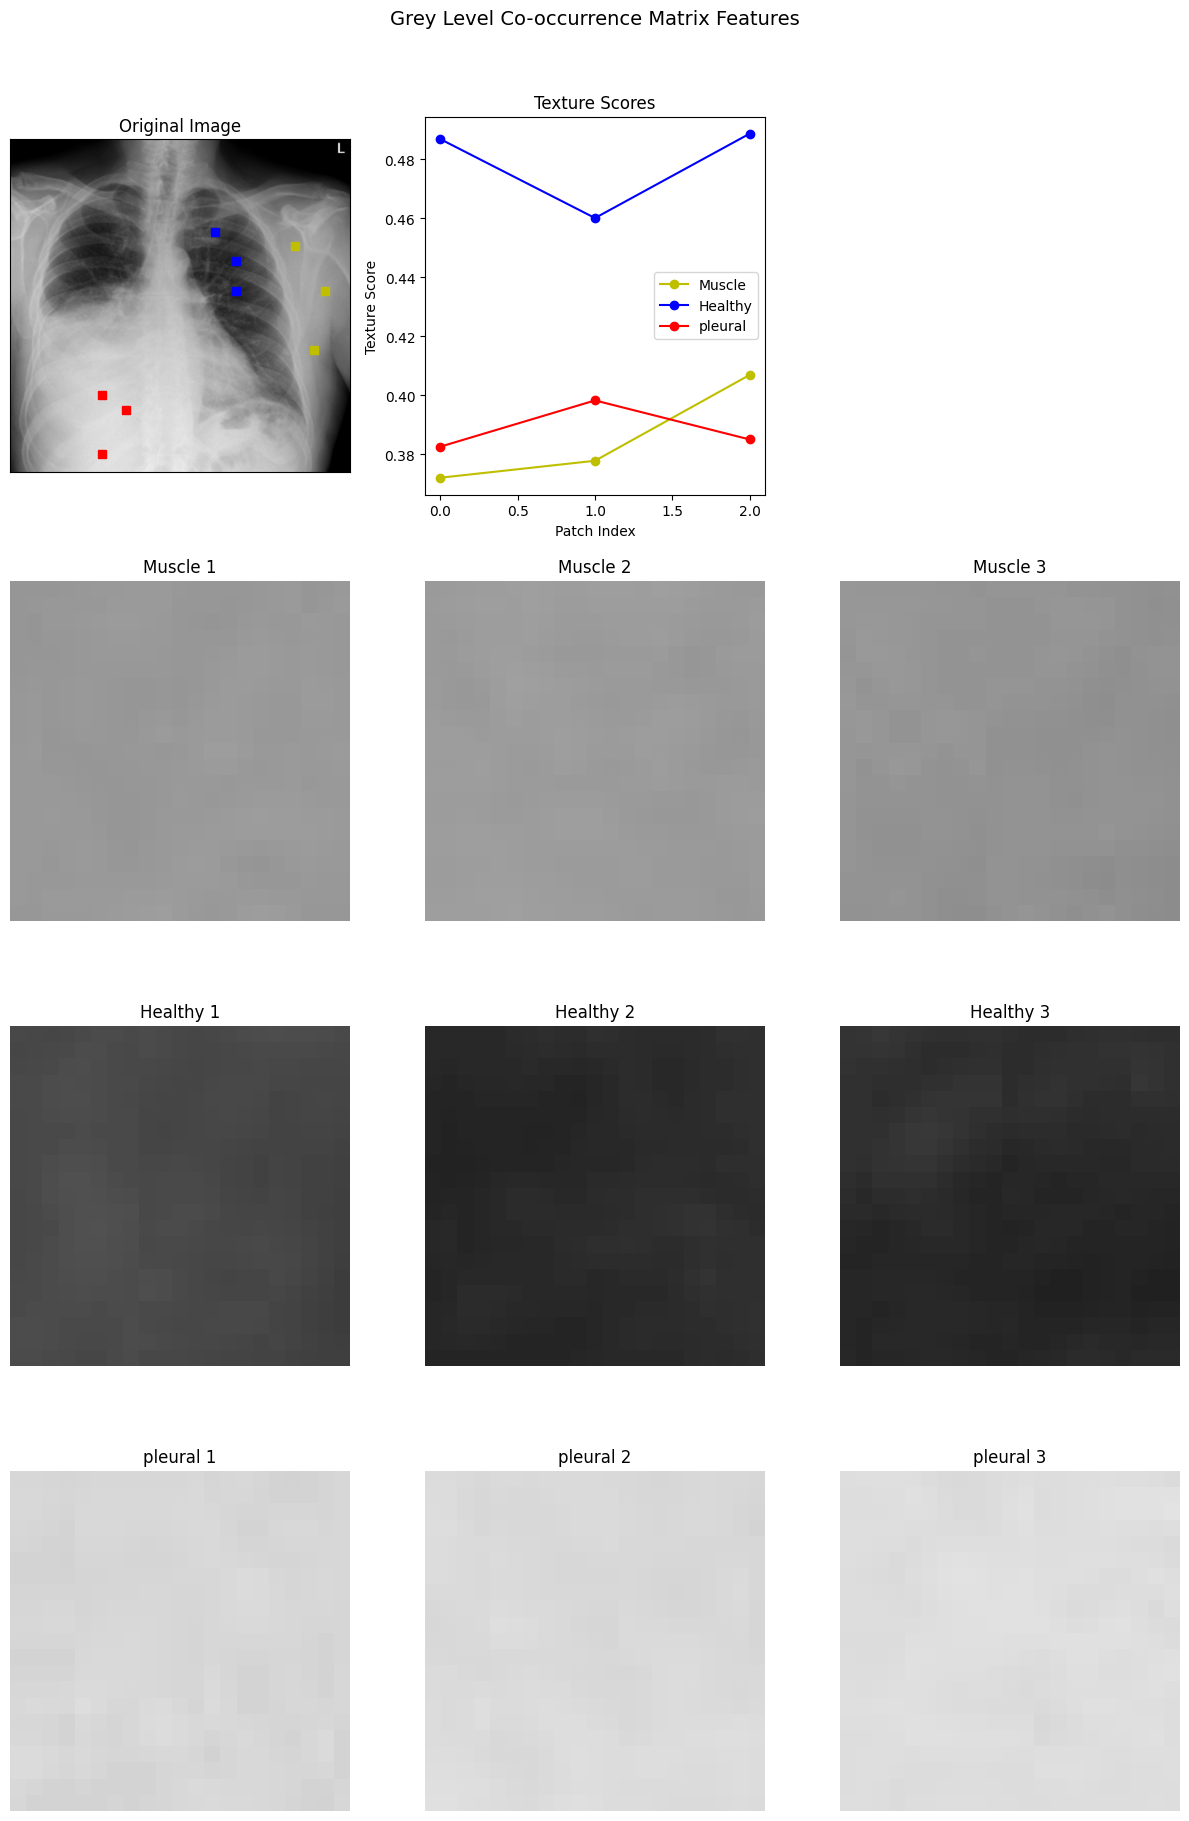

In [ ]:
weights = {
    'dissimilarity': 0.1,
    'correlation': 0.1,
    'homogeneity': 0.3,
    'energy': 0.4,
    'short_run_emphasis': 0.1
}
muscle_locations = [(350, 950), (500, 1050), (700, 1015)]
healthy_locations = [(300, 680), (400, 750), (500, 750)]
pleural_locations = [(850, 300), (900, 380), (1050, 300)]

analyze_texture_features(weights,
                         image_effusion,
                         muscle_locations,
                         healthy_locations,
                         pleural_locations,
                         "pleural")

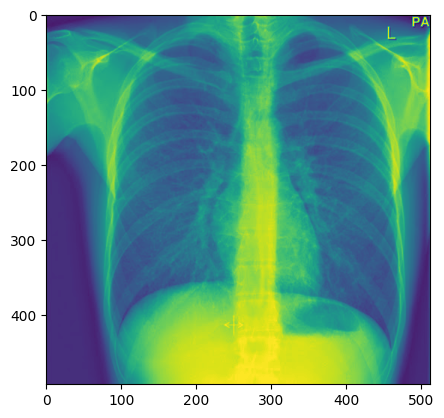

In [ ]:
plt.imshow(image_inflitration)

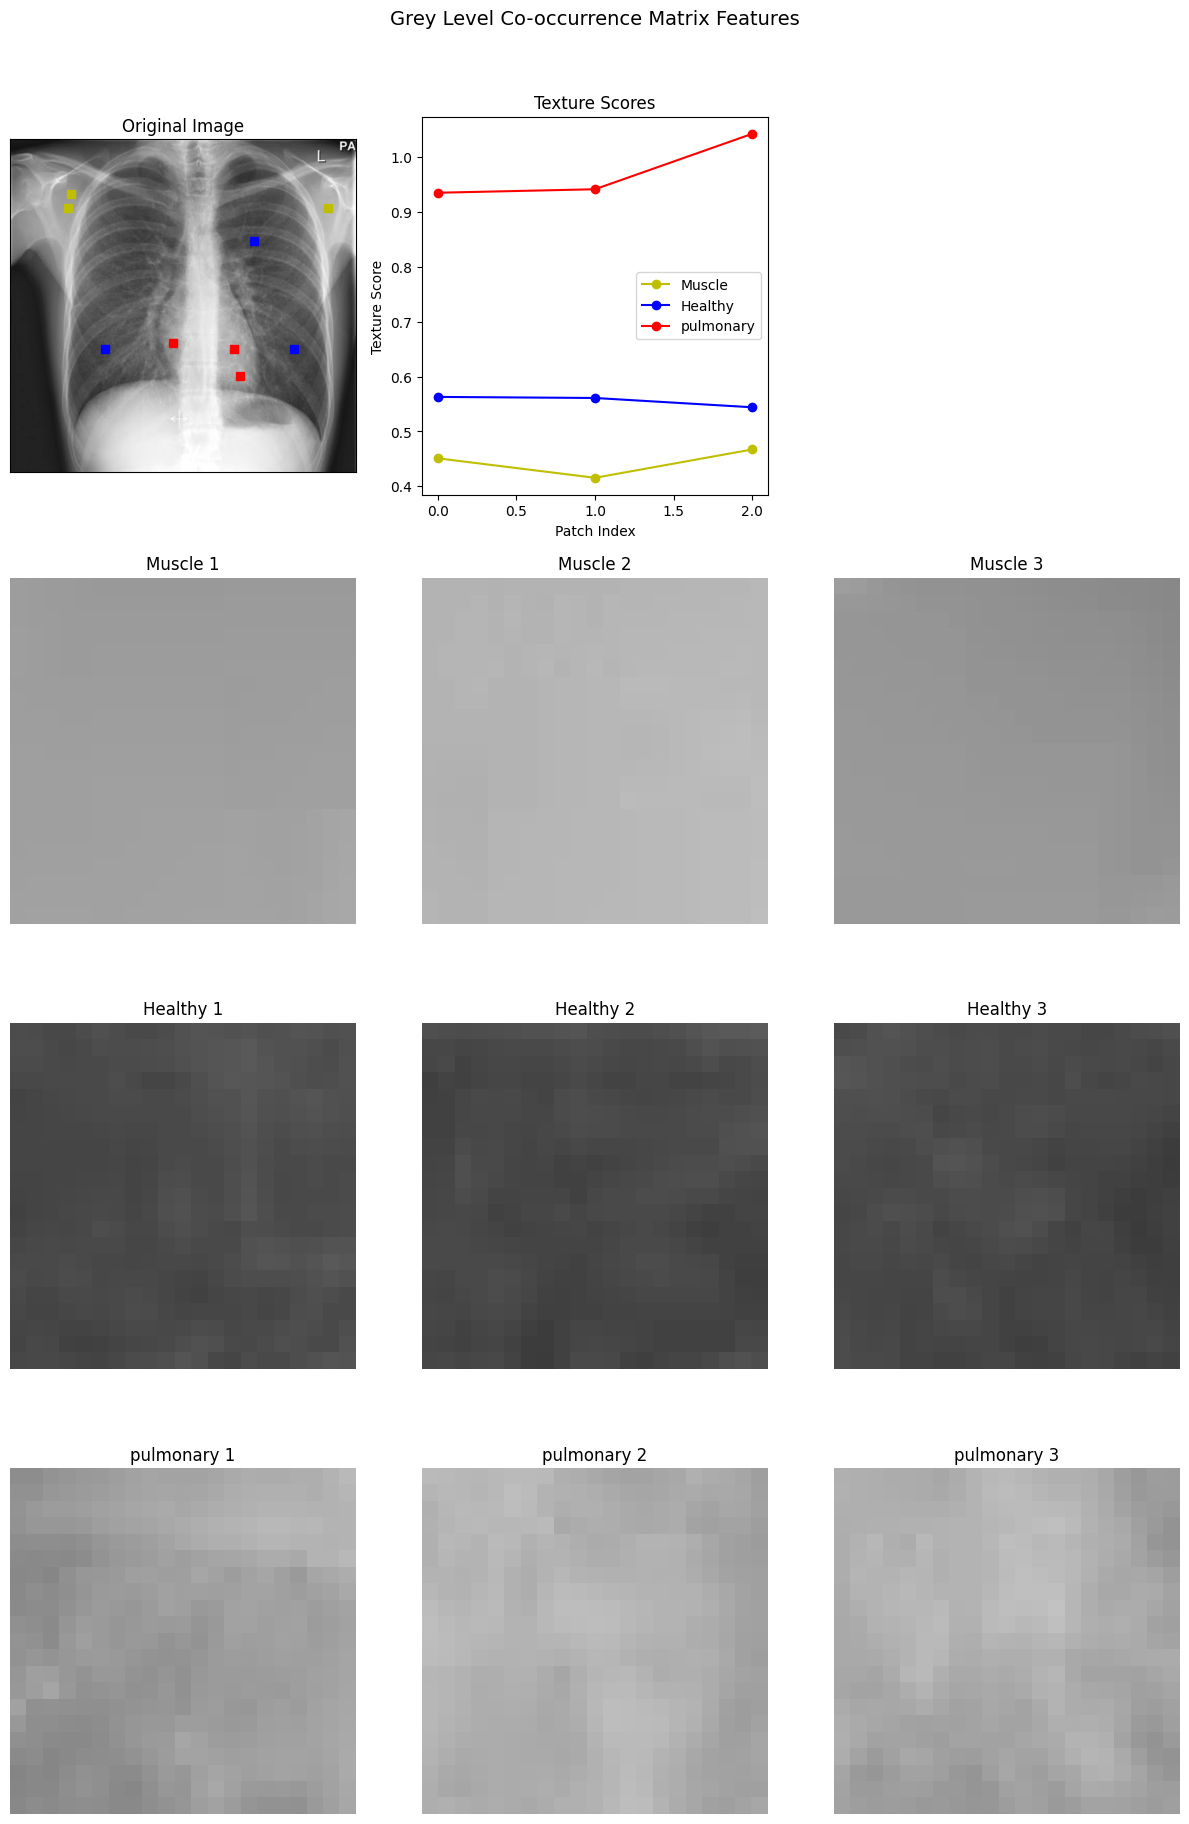

In [ ]:
weights = {
    'dissimilarity': 0.1,
    'correlation': 0.1,
    'homogeneity': 0.3,
    'energy': 0.4,
    'short_run_emphasis': 0.1
}
muscle_locations  = [(90, 75), (90, 460), (70, 80)]
healthy_locations = [(300, 130), (140, 350), (300, 410)]
pulmonary_locations = [(290, 230), (300, 320), (340, 330)]

analyze_texture_features(weights,
                         image_inflitration,
                         muscle_locations,
                         healthy_locations,
                         pulmonary_locations,
                         "pulmonary")

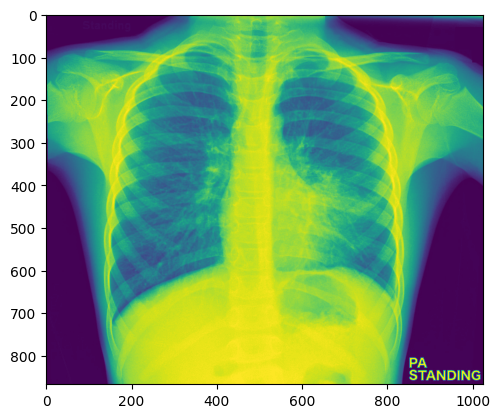

In [ ]:
plt.imshow(image_pneumonia)

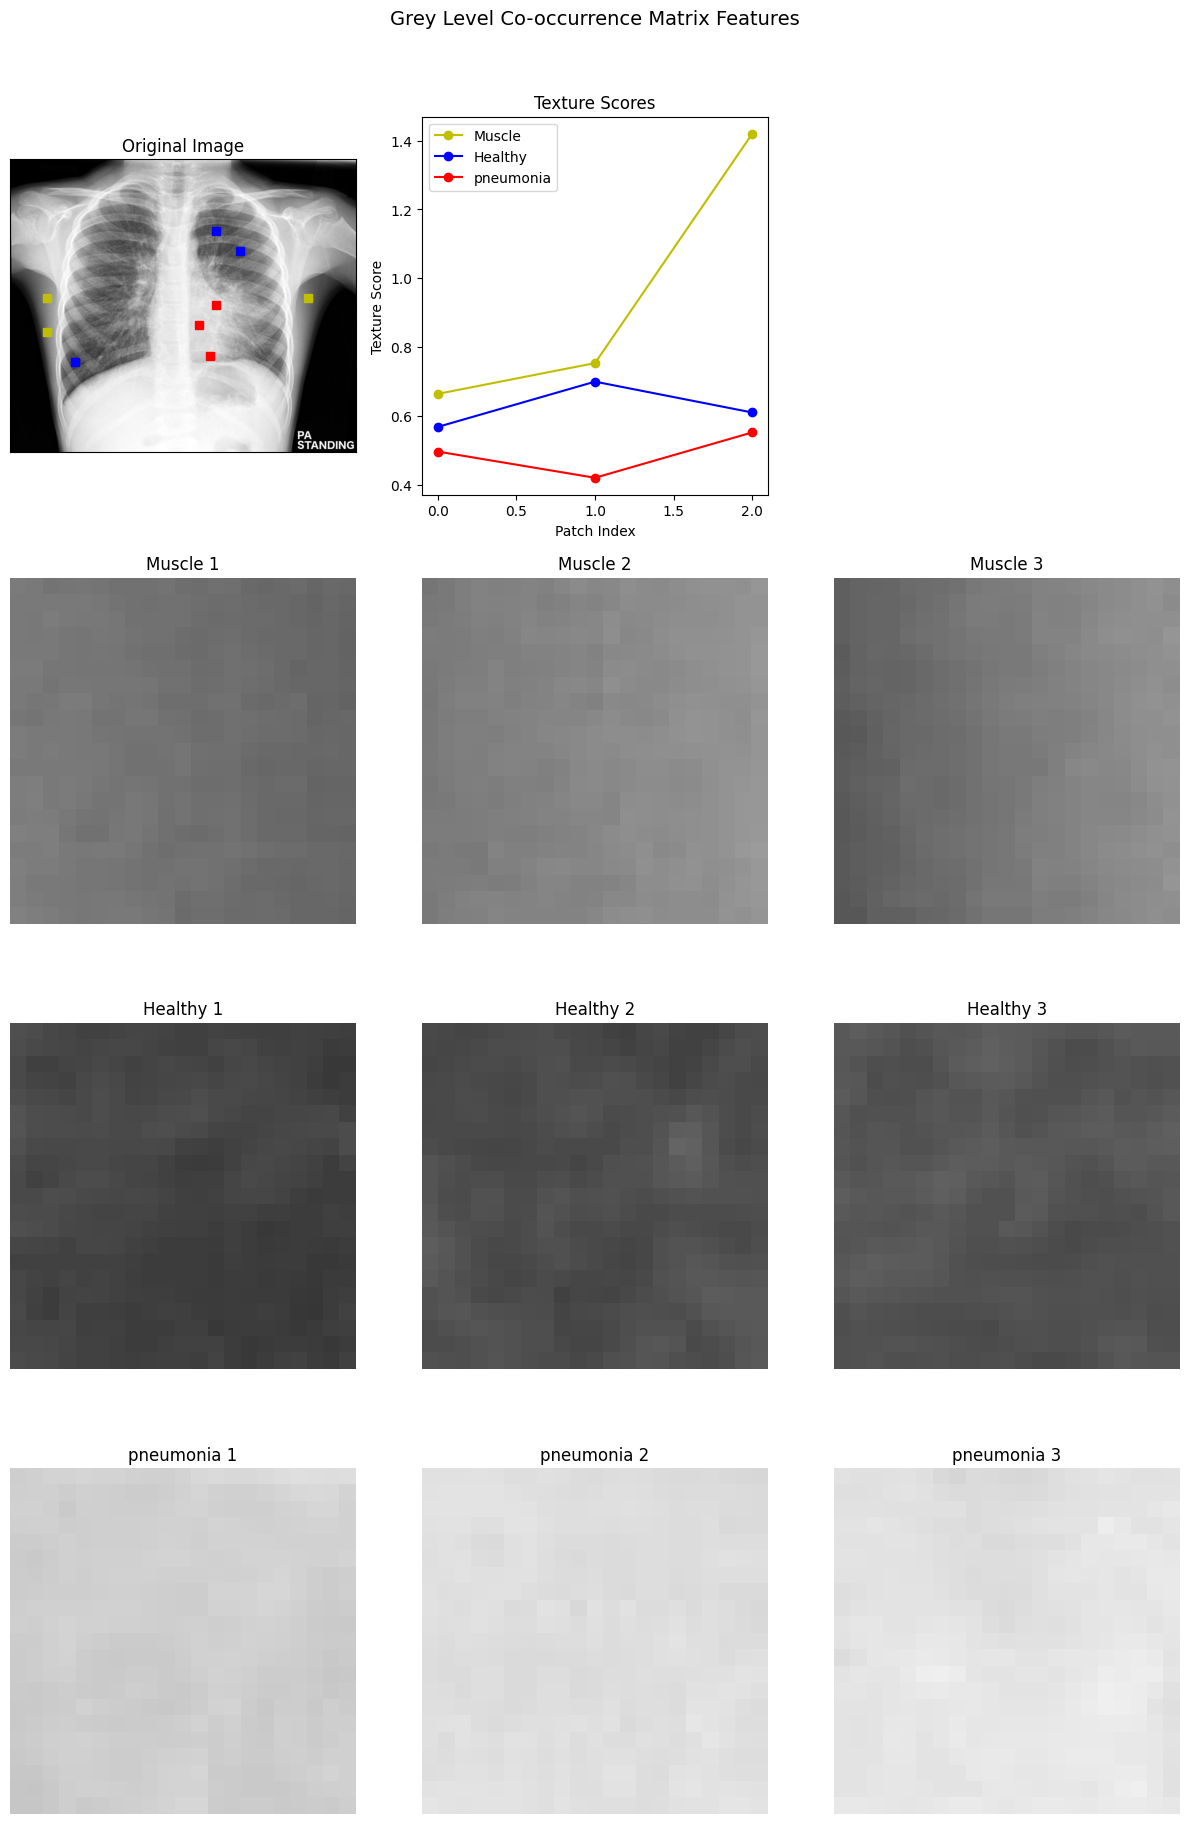

In [ ]:
weights = {
    'dissimilarity': 0.1,
    'correlation': 0.1,
    'homogeneity': 0.3,
    'energy': 0.4,
    'short_run_emphasis': 0.1
}
muscle_locations  = [(400, 870), (400, 100), (500, 100)]
healthy_locations = [(590, 180), (200, 600), (260, 670)]
pneumonia_locations = [(570, 580), (480, 550), (420, 600)]

analyze_texture_features(weights,
                         image_pneumonia,
                         muscle_locations,
                         healthy_locations,
                         pneumonia_locations,
                         "pneumonia")

# SECTION 2 - Textures

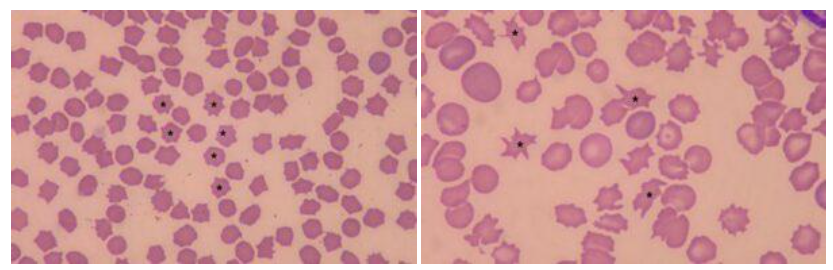

In [ ]:
image_acanthocytes = cv2.imread("Acanthocytes.jpeg", cv2.IMREAD_GRAYSCALE)
image_echinocytes = cv2.imread("Echinocytes.jpeg", cv2.IMREAD_GRAYSCALE)

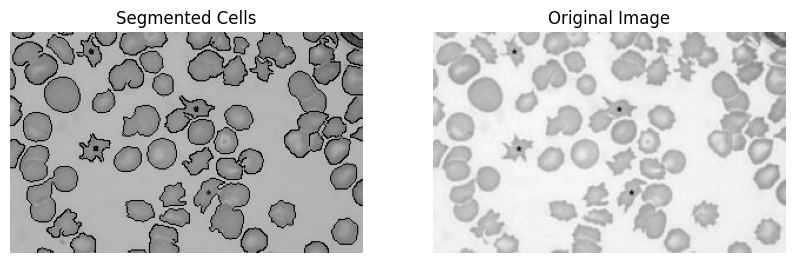

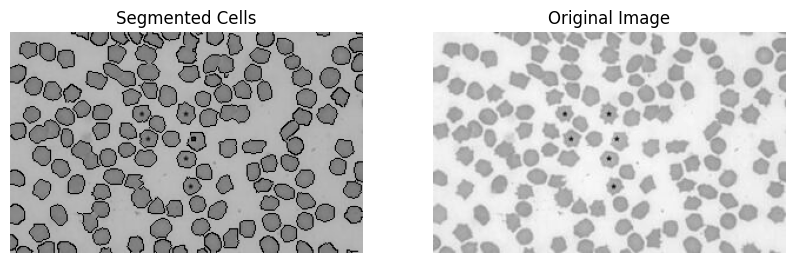

In [ ]:
def segment_cells(imag, noise_kernel, lower_t, upper_t):


    blurred = cv2.GaussianBlur(imag, noise_kernel, 0)

    edges = cv2.Canny(blurred, lower_t, upper_t)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    output_image = imag.copy()
    cv2.drawContours(output_image, contours, -1, (0, 255, 0), 1)

    plt.figure(figsize=(10, 10))
    plt.subplot(2,2,1)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title('Segmented Cells')
    plt.axis('off')

    plt.subplot(2,2,2)
    plt.imshow(imag, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

segment_cells(image_acanthocytes, (3,3), 50, 150)
segment_cells(image_echinocytes, (3,3), 50, 150)


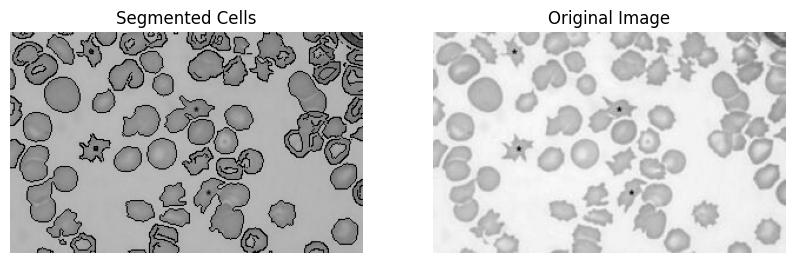

In [ ]:
segment_cells(image_acanthocytes, (3,3), 20, 50)


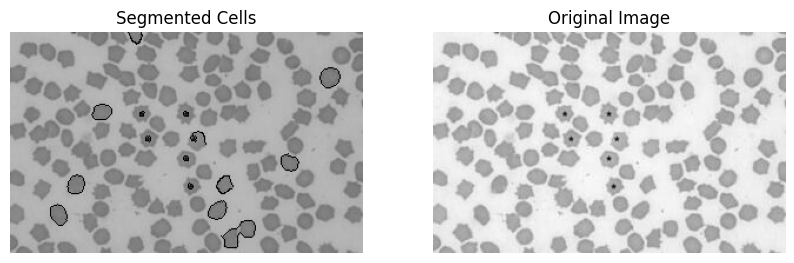

In [ ]:
segment_cells(image_echinocytes, (7,7), 50, 150)

### 2D:  Design software to classify the shapes and differentiate the normal and abnormal cells in each image. Aim for >90% accuracy

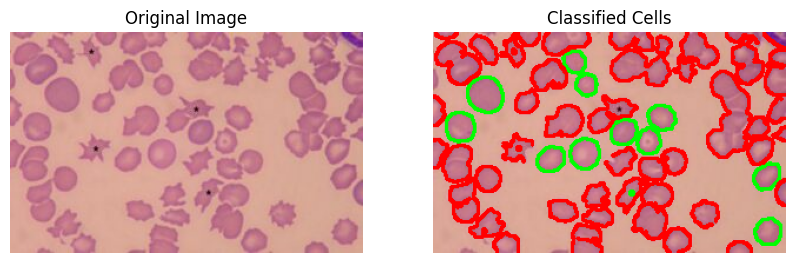

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

acanthocytes_path = 'Acanthocytes.jpeg'
echinocytes_path = 'Echinocytes.jpeg'
image_acanthocytes = cv2.imread(acanthocytes_path)
image_echinocytes = cv2.imread(echinocytes_path)

# Circularity
def calculate_circularity(contour):
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    if perimeter == 0:
        return 0
    return 4 * np.pi * (area / (perimeter * perimeter))

# Compactness
def calculate_compactness(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return (perimeter * perimeter) / area

# Eccentricity
def calculate_eccentricity(contour):
    try:
        (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
        eccentricity = np.sqrt(1 - (MA / ma) ** 2) if ma != 0 else 0
        return eccentricity
    except:
        return 0


def classify_cells(image, circularity_tr, compactness_tr, eccentricity_tr):

    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    normal_cells = []
    abnormal_cells = []
    for contour in contours:
        if cv2.contourArea(contour) < 5:
            continue

        circularity = calculate_circularity(contour)
        compactness = calculate_compactness(contour)
        eccentricity = calculate_eccentricity(contour)

        if circularity > circularity_tr and compactness < compactness_tr and eccentricity < eccentricity_tr:
            normal_cells.append(contour)
        else:
            abnormal_cells.append(contour)


    output_image = image.copy()
    cv2.drawContours(output_image, normal_cells, -1, (0, 255, 0), 2)
    cv2.drawContours(output_image, abnormal_cells, -1, (0, 0, 255), 2)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Classified Cells')
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

classify_cells(image_acanthocytes,
               circularity_tr = 0.8,
               compactness_tr = 40,
               eccentricity_tr = 0.8)


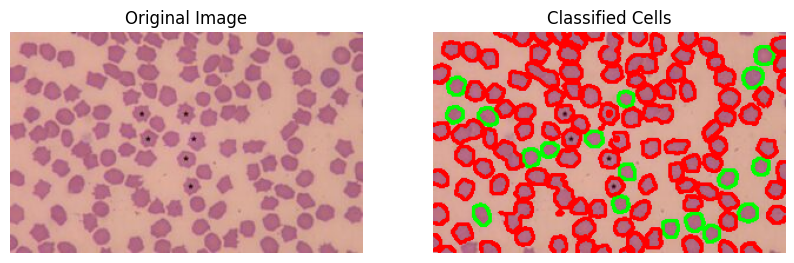

In [ ]:
classify_cells(image_echinocytes,
               circularity_tr = 0.85,
               compactness_tr = 40,
               eccentricity_tr = 0.8)

# SECTION 3 - Image registration

## 3D:  Write software to perform automatic, keypoint-based registration.

In [ ]:
elon = cv2.imread('elon.png')
monk = cv2.imread('monk2.png')

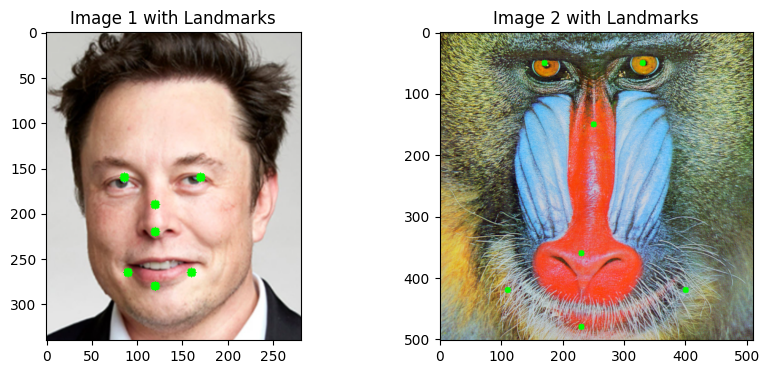

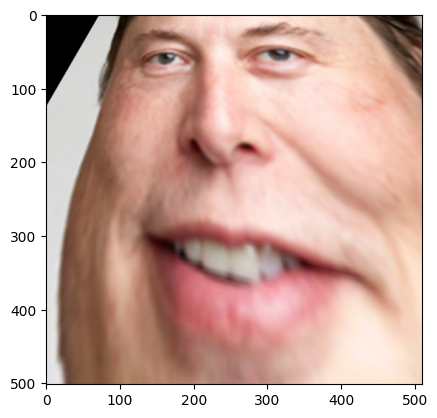

In [ ]:
gray1 = cv2.cvtColor(elon, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(monk, cv2.COLOR_BGR2GRAY)

points_image1 = np.array([[86, 160], [170, 160], [120, 190], [120, 220], [90, 265], [120, 280], [160, 265]])
points_image2 = np.array([[170, 50], [330, 50], [250, 150], [230, 360], [110, 420], [230, 480], [400, 420]])


image1_landmarks = elon.copy()
image2_landmarks = monk.copy()
for point in points_image1:
    cv2.circle(image1_landmarks, tuple(point), 5, (0, 255, 0), -1)
for point in points_image2:
    cv2.circle(image2_landmarks, tuple(point), 5, (0, 255, 0), -1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Image 1 with Landmarks")
plt.imshow(cv2.cvtColor(image1_landmarks, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title("Image 2 with Landmarks")
plt.imshow(cv2.cvtColor(image2_landmarks, cv2.COLOR_BGR2RGB))
plt.show()



matrix_homography, _ = cv2.findHomography(points_image1, points_image2, cv2.RANSAC)
registered_image_homography = cv2.warpPerspective(elon, matrix_homography, (monk.shape[1], monk.shape[0]))
plt.imshow(cv2.cvtColor(registered_image_homography, cv2.COLOR_BGR2RGB))
plt.show()

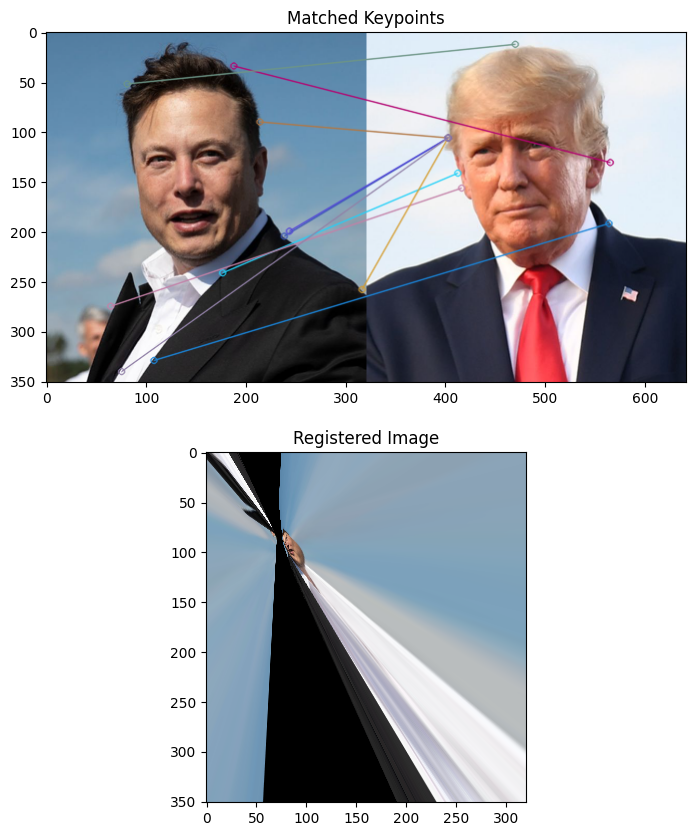

In [ ]:
elon = cv2.imread('elon2.png')
monk = cv2.imread('trump2.png')

monk = cv2.resize(monk, (elon.shape[1], elon.shape[0]))


gray1 = cv2.cvtColor(elon, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(monk, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

bf = cv2.BFMatcher()
matches = bf.match(descriptors1, descriptors2)

matches = sorted(matches, key=lambda x: x.distance)

matched_image = cv2.drawMatches(elon, keypoints1, monk, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

H, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

registered_image = cv2.warpPerspective(elon, H, (monk.shape[1], monk.shape[0]))

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title("Matched Keypoints")
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 1, 2)
plt.title("Registered Image")
plt.imshow(cv2.cvtColor(registered_image, cv2.COLOR_BGR2RGB))
plt.show()

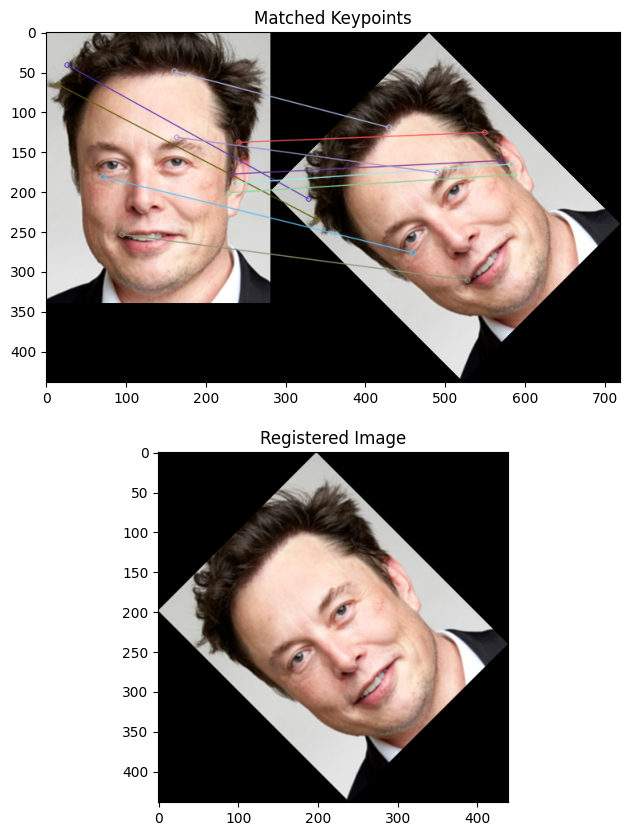

In [6]:
elon = cv2.imread('elon.png')
monk = cv2.imread('elon.png')


monk = ndimage.rotate(monk, 45)

gray1 = cv2.cvtColor(elon, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(monk, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

bf = cv2.BFMatcher()
matches = bf.match(descriptors1, descriptors2)

matches = sorted(matches, key=lambda x: x.distance)

matched_image = cv2.drawMatches(elon, keypoints1, monk, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

H, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

registered_image = cv2.warpPerspective(elon, H, (monk.shape[1], monk.shape[0]))

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title("Matched Keypoints")
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 1, 2)
plt.title("Registered Image")
plt.imshow(cv2.cvtColor(registered_image, cv2.COLOR_BGR2RGB))
plt.show()

## 3F:  Write software to perform image-based registration (e.g. Histogram matching, Entropy)

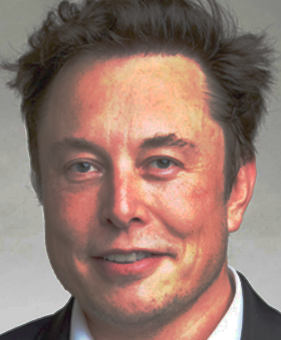

In [18]:
elon = cv2.imread('elon.png')
monk = cv2.imread('monk2.png')

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure, transform

def histogram_matching(source_image, reference_image):
    matched = exposure.match_histograms(source_image, reference_image)
    return matched



matched_image = histogram_matching(elon, monk)

cv2_imshow(matched_image)